In [13]:
import os
import os.path as osp
import sys
import time
import argparse
import numpy as np

import torch
import torch.nn as nn
from torch.backends import cudnn
from torch.utils.data import DataLoader

import model
from feeder.feeder_visualization import Feeder
from utils import to_numpy
from utils.logging import Logger 
from utils.meters import AverageMeter
from utils.serialization import load_checkpoint

from sklearn.metrics import precision_score, recall_score
from sklearn.manifold import TSNE
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [61]:
os.environ['CUDA_VISIBLE_DEVICES'] = str(3)
ckpt_path = '../face.pairnode/logs/best.ckpt'
seed = 0

In [159]:
np.random.seed(seed)
torch.manual_seed(seed)
cudnn.benchmark = True

trainset = Feeder('../facedata/CASIA.feas.train.npy', 
                  '../facedata/knn.graph.CASIA.train.kdtree.npy', 
                  '../facedata/CASIA.labels.npy', 
                  seed, 
                  [100,5],
                  5)
valset = Feeder( '../facedata/512.fea.npy', 
                 '../facedata/knn.graph.512.bf.npy', 
                 '../facedata/512.labels.npy', 
                 seed, 
                 [100,10],
                 10,)
                 #train=False)

ckpt = load_checkpoint(ckpt_path)
net = model.gcn()
net.load_state_dict(ckpt['state_dict'])
net = net.cuda()

=> Loaded checkpoint '../face.pairnode/logs/best.ckpt'


In [160]:
def plot_embedding(X,Y, cid, ohidcs, A):
    #x_min, x_max = np.min(X,0), np.max(X,0)
    #X = (X-x_min) / (x_max  - x_min)
    plt.figure(figsize=(20,20))
    for i in xrange(Y.shape[0]):
        
        if i==cid:
            c='g'
            s=500
        elif Y[i]==Y[cid]:
            c = 'r'
            s = 20
        else:
            c = 'b'
            s = 20
        plt.scatter(X[i,0], X[i,1], s,color=c)
    #for ohi in ohidcs:
    #    c='r' if Y[cid]==Y[ohi] else 'gray'
    #    w=1 if Y[cid]==Y[ohi] else 0.5
    #    if Y[cid]==Y[ohi]:
    #        plt.plot([X[cid,0], X[ohi,0]],[X[cid,1], X[ohi,1]], linestyle='--', linewidth=w, color=c)
    edges = A.nonzero()
    edges = np.asarray(edges).T
    for e in edges:
        plt.plot([X[e[0],0], X[e[1],0]],[X[e[0],1], X[e[1],1]], linestyle='--', linewidth=0.5, color='gray')
    
    plt.show()

In [192]:
idx = 1112
(feat, A, cid, one_hop_idcs), edge_labels, labels = trainset[idx]
feat, A, cid, one_hop_idcs, edge_labels, labels = map(to_numpy, (feat, A, cid, one_hop_idcs, edge_labels, labels))

ulabel = np.unique(labels)
lmap = {j:i for i,j in enumerate(ulabel)}
labels = [lmap[l] for l in labels]
labels = np.asarray(labels)

In [193]:
feat_tsne = TSNE(n_components=2).fit_transform(feat)


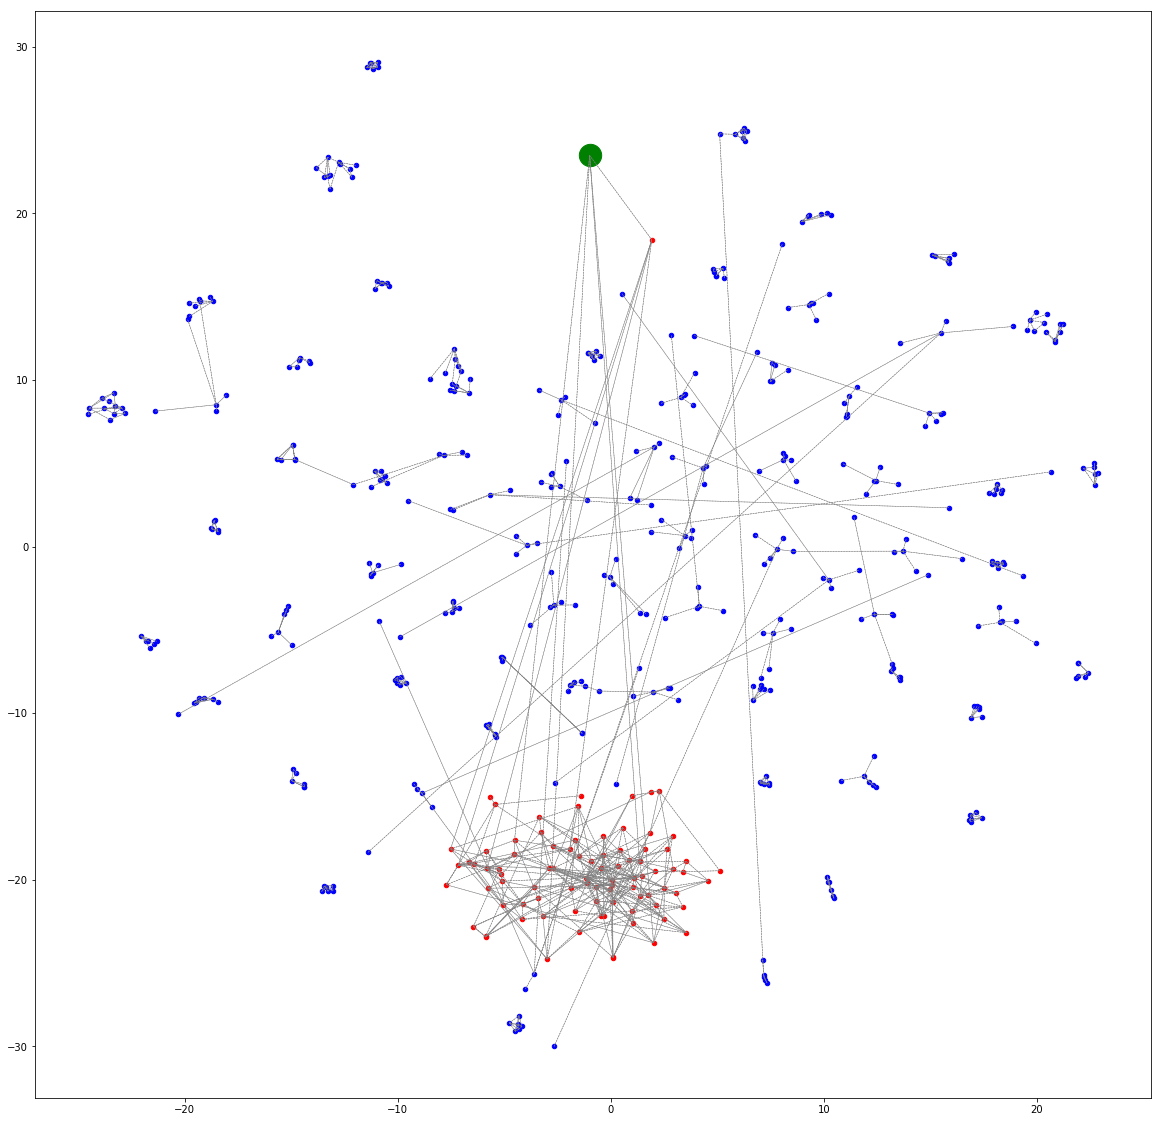

In [194]:
plot_embedding(feat_tsne, labels, cid, one_hop_idcs, A)

In [195]:
aa = A.nonzero()
aa= np.nonzero(A)
np.asarray(aa).shape

(2, 1690)

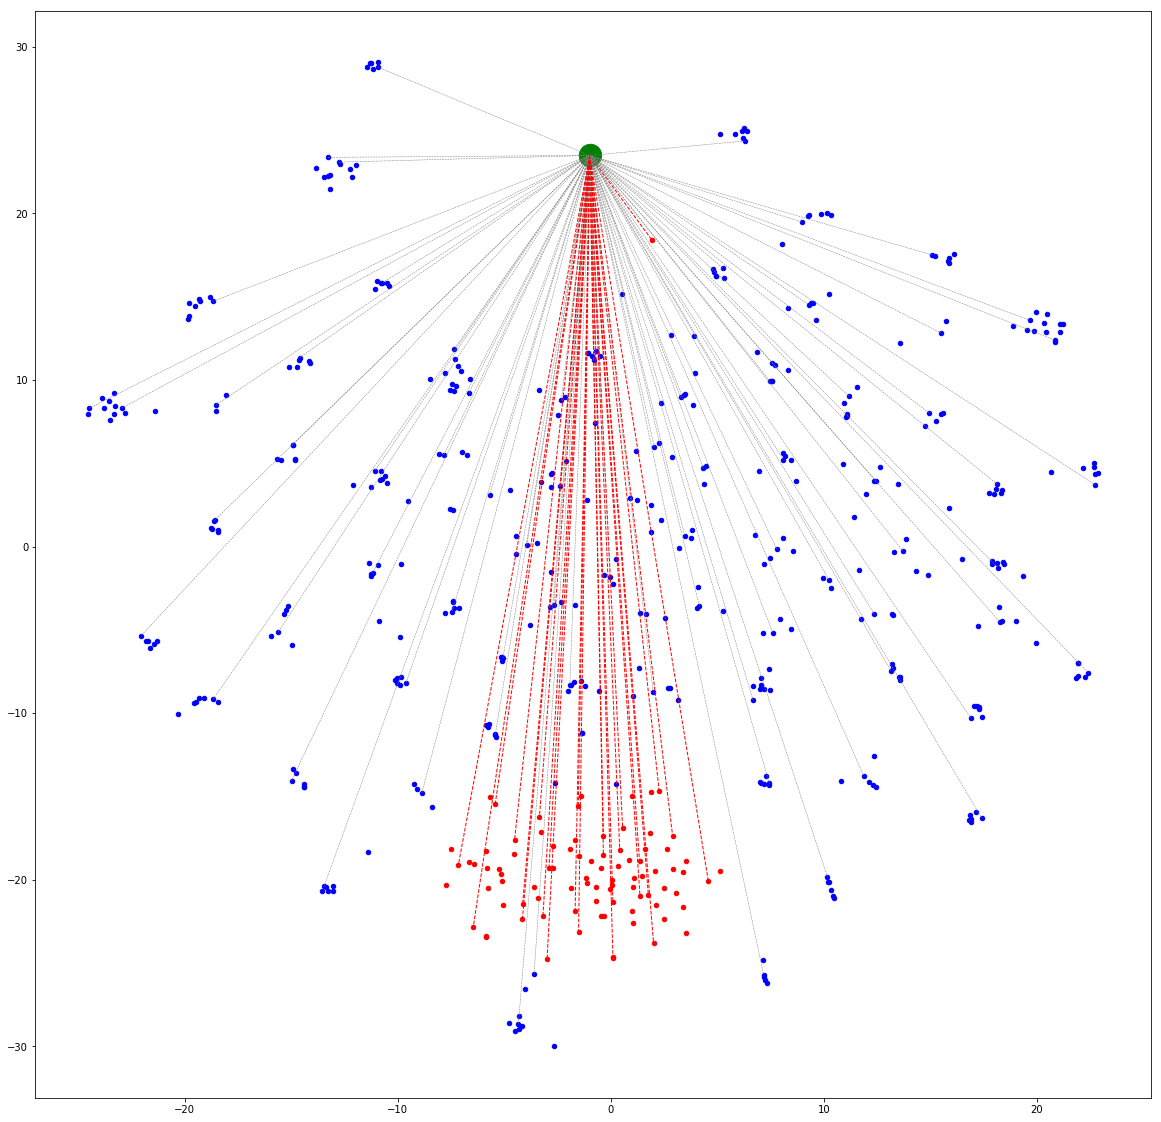

In [196]:
def plot_knn(X,Y, cid, ohidcs, A):
    #x_min, x_max = np.min(X,0), np.max(X,0)
    #X = (X-x_min) / (x_max  - x_min)
    plt.figure(figsize=(20,20))
    for i in xrange(Y.shape[0]):
        
        if i==cid:
            c='g'
            s=500
        elif Y[i]==Y[cid]:
            c = 'r'
            s = 20
        else:
            c = 'b'
            s = 20
        plt.scatter(X[i,0], X[i,1], s,color=c)
    for ohi in ohidcs:
        c='r' if Y[cid]==Y[ohi] else 'gray'
        w=1 if Y[cid]==Y[ohi] else 0.5
        
        plt.plot([X[cid,0], X[ohi,0]],[X[cid,1], X[ohi,1]], linestyle='--', linewidth=w, color=c)
    
    plt.show()
plot_knn(feat_tsne, labels, cid, one_hop_idcs, A)